# Analysis of children's health data from Kolding

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas
import seaborn
import xml.etree.ElementTree as ET

In [2]:
%matplotlib inline

## Load data into a pandas DataFrame

In [3]:
boern_xml = 'Børn.xml'
with open(boern_xml) as fin:
    tree = ET.parse(fin)
    root = tree.getroot()
    child_data = []
    for child in root:
        #print(child.tag, child.attrib)
        child_attrib_list = [0] * 7
        for i, child_attrib in enumerate(child):
            #print(child_attrib.tag, child_attrib.text)
            child_attrib_list[i] = child_attrib.text
        child_data.append(child_attrib_list)

col_names = ['Child', 'Year', 'Gender', 'District', 'Weight', 'Height', 'Head Circumference']
child_df = pandas.DataFrame(child_data, columns=col_names)

In [4]:
numeric_cols = ['Child', 'Year', 'Weight', 'Height', 'Head Circumference']
child_df[[*numeric_cols]] = child_df[[*numeric_cols]].apply(pandas.to_numeric)

In [5]:
print('Read {:d} entries for {:d} children.'.format(len(child_df), len(child_df['Child'].unique())))

Read 116242 entries for 26125 children.


## Calculate children's age at each measurment

Note that first measurment for each child is taken at birth (age 0).
As a further data cleaning step, keep only the measurement with the largest height for each child in case multiple
measurements have been recorded within the same year.

In [6]:
child_grouped = child_df.groupby('Child')

child_age_dfs = []
for child_id, child_data in child_grouped:
    #print(child_id)
    min_year = child_data['Year'].min()
    child_data = pandas.concat([child_data, child_data['Year'] - min_year], axis=1)
    child_data.columns = col_names + ['Age']
    #print(child_data)

    child_data_cleaned_list = []
    for a, d in child_data.groupby('Age'):
        if len(d.shape) > 1:
            curr_cleaned = d.loc[d['Height'].argmax(), ]
        else:
            curr_cleaned = d
        child_data_cleaned_list.append(curr_cleaned)
    child_data_cleaned = pandas.concat(child_data_cleaned_list, axis=1)
    child_age_dfs.append(child_data_cleaned.transpose())

In [7]:
child_age_df = pandas.concat(child_age_dfs)

In [8]:
print('{:d} entries for {:d} children left.'.format(len(child_age_df), len(child_age_df['Child'].unique())))

52701 entries for 26125 children left.


### Example: Number of measurements per age group

All measurements for children younger than 2 have been removed in plot below.

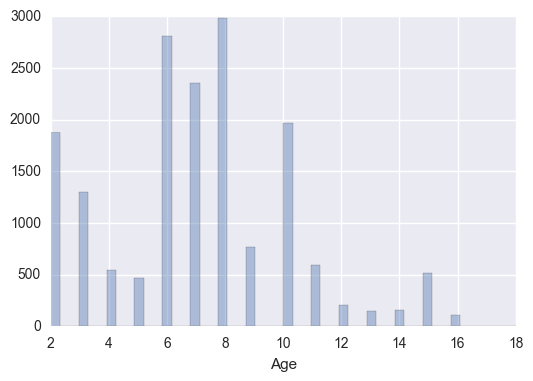

In [9]:
age_vec = child_age_df['Age']
age_vec_gt_1 = age_vec[age_vec > 1]
seaborn.distplot(age_vec_gt_1, kde=False)

## Export cleaned data to CSV

In [10]:
child_age_df.to_csv('children.csv')

## Add BMI column

In [11]:
child_age_df['BMI'] = child_age_df['Weight'] / ((child_age_df['Height']/100)**2)

In [12]:
child_age_df.head()

,Child,Year,Gender,District,Weight,Height,Head Circumference,Age,BMI
111117,1,2013,Hankøn,Nordvest,10,69,45,0,21.004
55806,2,2008,Hankøn,Sydvest,22.6,122.5,0,0,15.0604
65306,2,2009,Hankøn,Sydvest,27.7,130.5,0,1,16.2652
101794,2,2012,Hankøn,Sydvest,40.4,146.5,0,4,18.8237
103855,3,2012,Hankøn,Ikke angivet,19.7,114,0,0,15.1585


## Plot BMI across districts and genders

In [13]:
child_age_df.replace('Hankøn', 'male', inplace=True)
child_age_df.replace('Hunkøn', 'female', inplace=True)

In [14]:
allowed_districts = set(['Nordvest', 'Sydvest', 'Ikke angivet', 'Syd', 'Nord'])
sane_district_rows = child_age_df['District'].isin(allowed_districts)
print('{:d} out of {:d} rows had sane district names'.format(sum(sane_district_rows), len(child_age_df)))
child_age_with_district_df = child_age_df.loc[sane_district_rows,]

52586 out of 52701 rows had sane district names


In [15]:
known_districts = set(['Nordvest', 'Sydvest', 'Syd', 'Nord'])
known_district_rows = child_age_with_district_df['District'].isin(known_districts)
print('{:d} out of {:d} rows had known district value'.format(sum(known_district_rows),
                                                              len(child_age_with_district_df)))
child_age_with_district_df = child_age_with_district_df.loc[known_district_rows,]

36023 out of 52586 rows had known district value


In [16]:
max_bmi_allowed = 30
sane_bmi_rows = child_age_with_district_df['BMI'] <= max_bmi_allowed
print('{:d} rows had too high BMI values (>{:d}).'.format(len(child_age_with_district_df) - sum(sane_bmi_rows),
                                                     max_bmi_allowed))
child_age_with_district_bmi_df = child_age_with_district_df.loc[sane_bmi_rows,]

384 rows had too high BMI values (>30).


In [17]:
min_bmi_allowed = 10
sane_bmi_rows = child_age_with_district_bmi_df['BMI'] >= min_bmi_allowed
print('{:d} rows had too low BMI values (<{:d}).'.format(len(child_age_with_district_bmi_df) - sum(sane_bmi_rows),
                                                     min_bmi_allowed))
child_age_with_district_bmi_df = child_age_with_district_bmi_df.loc[sane_bmi_rows,]

388 rows had too low BMI values (<10).


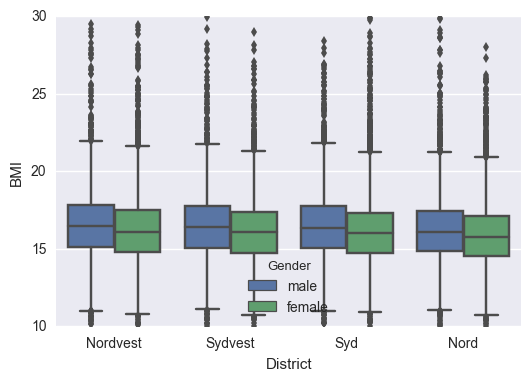

In [18]:
ax = seaborn.boxplot(x="District", y="BMI", hue='Gender', data=child_age_with_district_bmi_df)